# **TRABALHO 1**

Alunos: Fernanda Lacerda Matos Mascarenhas, Leandro José Gonçalves Pereira e Roney Felipe de Oliveira Miranda

### **Instala biblioteca necessária**

In [952]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Importa bibliotecas necessárias**

In [953]:
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, single, complete, average, ward, dendrogram
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import SilhouetteVisualizer

### **Variáveis globais**

In [954]:
SEED = 42 # Semente para gerar números aleatórios
MAX_GRUPOS = 5 # Número de classes da nossa base artificial
QTDE_EXEMPLOS = 300 # Número de linhas da nossa base artificial
NUM_CLUSTERS = 4 # Número de clusters definido a partir da avaliação do KMeans na base artificial
MAX_CLUSTERS = 8 # Número máximo de clusters para o qual testaremos o KMeans na base artificial

# **Base de Dados Artifical**

Utiliza a função make_blobs para gerar uma base de dados artificial

In [955]:
x_artificial, y_artificial = make_blobs(centers = MAX_GRUPOS, n_samples = QTDE_EXEMPLOS, random_state = SEED, cluster_std = 0.7)

Mostra as 10 primeiras linhas da base artificial

In [956]:
x_artificial[:10]

array([[-1.18886749,  9.1364906 ],
       [ 0.98728986,  4.96207939],
       [-2.36299311,  7.64251704],
       [ 4.48345489,  2.47297003],
       [-3.43892786,  9.15208899],
       [-8.91695739,  7.1688442 ],
       [ 1.60762449,  3.55665802],
       [-6.826564  , -7.35412279],
       [-8.56948194,  7.30063659],
       [ 2.42625072,  4.01931979]])

Mostra os 10 primeiros rótulos da base de dados artificial

In [957]:
y_artificial[:10]

array([0, 4, 0, 1, 0, 3, 4, 2, 3, 4])

Plota os dados da base de dados artificial

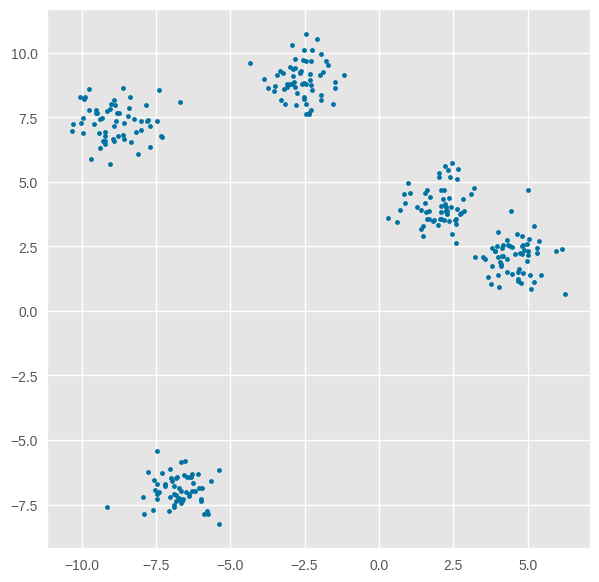

In [958]:
plt.figure(figsize = (7, 7))
plt.plot(x_artificial[:,0],x_artificial[:,1],'.b')
plt.show()

Cria um vetor vazio para guardar o valor da silhueta calculado para cada algoritmo

In [959]:
silhouette_scores = []

### **KMeans**

Cra função para encapsular a execução do algoritmo KMeans

In [960]:
def algoritmo_kmeans(qtde_clusters, dataset):
  random.seed(SEED)
  centroides_iniciais = dataset[[random.randint(0, len(dataset)) for i in range(qtde_clusters)], :]

  kmeans = KMeans(n_init = 1, n_clusters = qtde_clusters, init = centroides_iniciais)
  kmeans.fit(dataset)

  return kmeans

Executa o KMeans com 2 até *MAX_CLUSTERS* grupos e calcula o Rand Index Score e Silhouette Score.

Guarda o melhor agrupamento baseado no maior Rand Index encontrado durante a execução

In [961]:
kmeans_silhouette_scores = []
kmeans_rand_scores = []
best_kmeans_rand_score = 0
best_kmeans = None

for i in range(2, MAX_CLUSTERS):
  kmeans = algoritmo_kmeans(i, x_artificial)

  ss = silhouette_score(x_artificial, kmeans.labels_, metric='euclidean')
  kmeans_silhouette_scores.append(ss)

  rand_score = adjusted_rand_score(y_artificial, kmeans.labels_)
  kmeans_rand_scores.append(rand_score)

  if rand_score > best_kmeans_rand_score:
    best_kmeans_rand_score = rand_score
    best_kmeans = kmeans

silhouette_scores.append(silhouette_score(x_artificial, best_kmeans.labels_, metric='euclidean')) # Calcula silhueta média do melhor agrupamento encontrado

Plota os gráficos de Rand Index e Silhuette Score calculados durante o loop do KMeans.

Exibe o melhor agrupamento encontrado pelo algoritmo KMeans

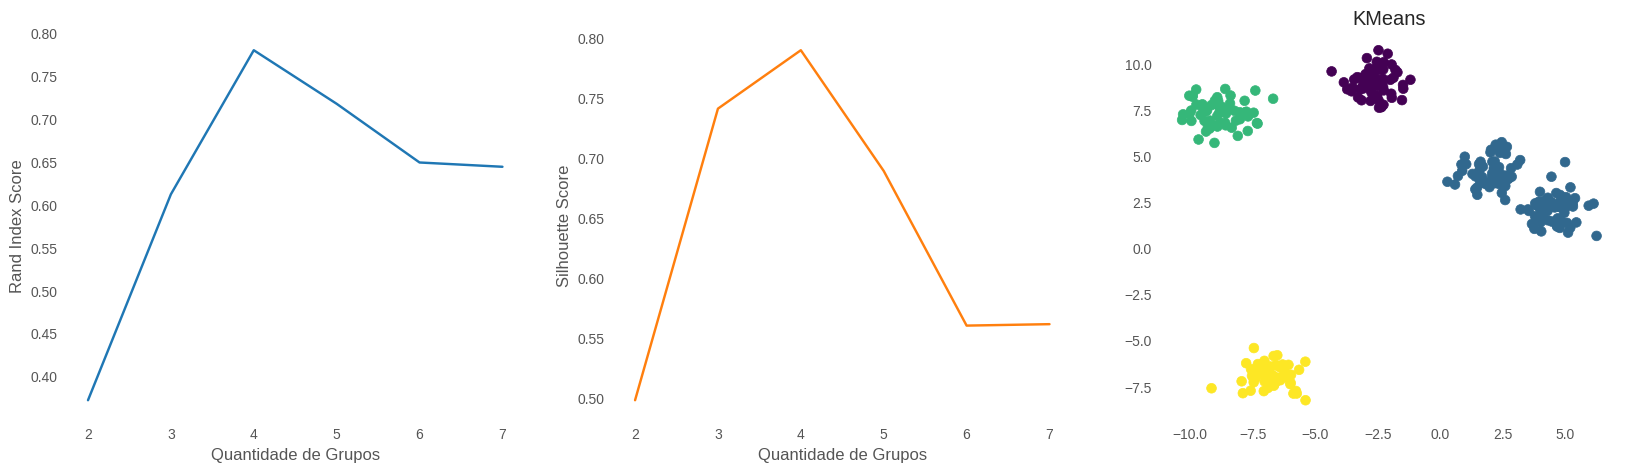

In [962]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))

axs[0].plot(range(2, MAX_CLUSTERS), kmeans_rand_scores, 'tab:blue')
axs[0].set_xlabel('Quantidade de Grupos')
axs[0].set_ylabel("Rand Index Score")
axs[0].set_facecolor("white")

axs[1].plot(range(2, MAX_CLUSTERS), kmeans_silhouette_scores, 'tab:orange')
axs[1].set_xlabel('Quantidade de Grupos')
axs[1].set_ylabel("Silhouette Score")
axs[1].set_facecolor("white")

axs[2].scatter(x_artificial[:,0], x_artificial[:,1], c = best_kmeans.labels_, cmap = "viridis")
axs[2].set_title("KMeans")
axs[2].set_facecolor("white")

Utiliza a biblioteca vista em sala para demonstrar o comportamento dos itens da base baseado na silhueta de cada item

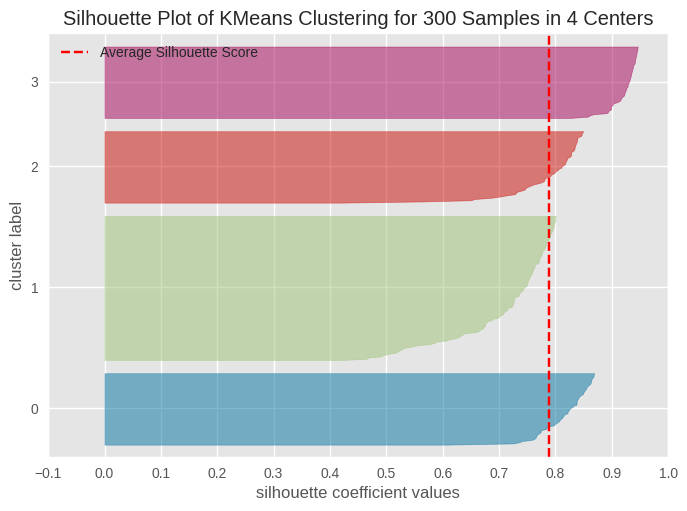

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 300 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [963]:
visualizer = SilhouetteVisualizer(best_kmeans, colors='yellowbrick')
visualizer.fit(x_artificial)
visualizer.show()

### **Algoritmos de Agrupamento Hierárquicos**

Função extraída do Scikit para exibir dendogramas utilizando a função *AgglomerativeClustering()*

In [964]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Calcula a distância entre todos os pontos da base de dados artificial e guarda a maior distância encontrada

In [965]:
distancias = pdist(x_artificial, 'euclidean')
index_maior_distancia = distancias.argmax()
maior_distancia = distancias[index_maior_distancia]

maior_distancia

19.515157726785127

#### **Single Linkage**

Cria uma função para encapsular a execução do algoritmo Single Linkage

In [966]:
def single_linkage(threshold, dataset):
  sl = AgglomerativeClustering(linkage = 'single', distance_threshold = threshold * maior_distancia, n_clusters = None).fit(dataset)
  
  return sl

Executa o Single Linkage com thresholds variando de 0% a 100% da maior distânca encontrada entre os pontos da base de dados artificial e calcula o Rand Index Score.

Guarda o melhor agrupamento baseado no maior Rand Index encontrado durante a execução

In [967]:
single_linkage_rand_scores = []
best_single_linkage_rand_score = 0
best_single_linkage = None
best_single_linkage_threshold = 0

for i in np.linspace(0, 1, 11):
  sl = single_linkage(i, x_artificial)

  rand_score = adjusted_rand_score(y_artificial, sl.labels_)
  single_linkage_rand_scores.append(rand_score)

  if rand_score > best_single_linkage_rand_score:
    best_single_linkage_rand_score = rand_score
    best_single_linkage = sl
    best_single_linkage_threshold = i

silhouette_scores.append(silhouette_score(x_artificial, best_single_linkage.labels_, metric='euclidean'))

Plota o gráfico do Rand Index calculado durante o loop do Single Linkage.

Exibe o melhor agrupamento encontrado pelo algoritmo Single Linkage

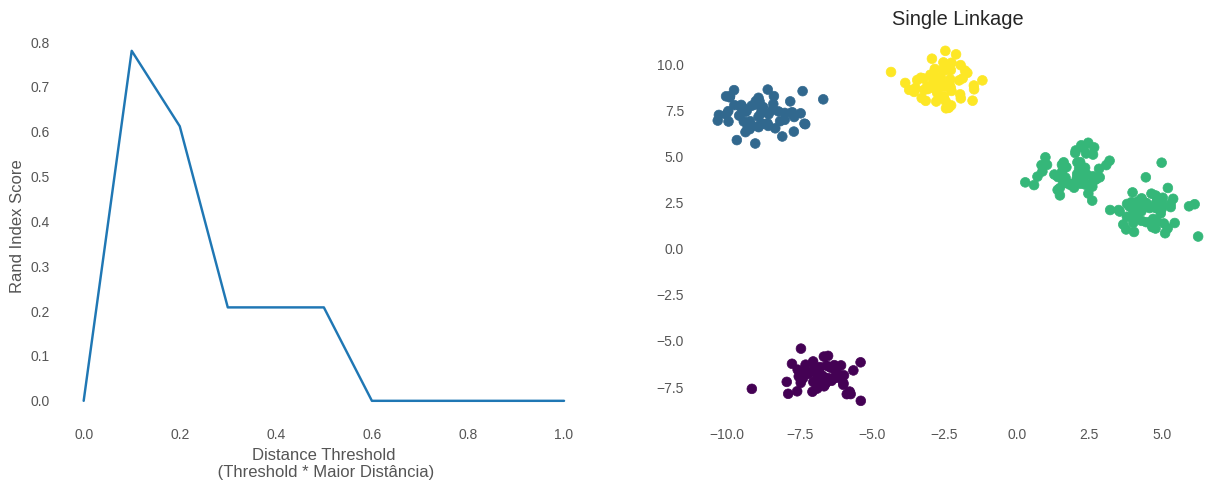

In [968]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(np.linspace(0, 1, 11), single_linkage_rand_scores, 'tab:blue')
axs[0].set_xlabel('Distance Threshold\n (Threshold * Maior Distância)')
axs[0].set_ylabel("Rand Index Score")
axs[0].set_facecolor("white")

axs[1].scatter(x_artificial[:,0], x_artificial[:,1], c = best_single_linkage.labels_, cmap = "viridis")
axs[1].set_title("Single Linkage")
axs[1].set_facecolor("white")

fig.show()

Exibe o dendrograma do respectivo Single Linkage (utilizamos o truncamento para uma melhor vizualização do dendograma já que como são muitos dados a exibição dos 300 pontos dificultava a interpretação)

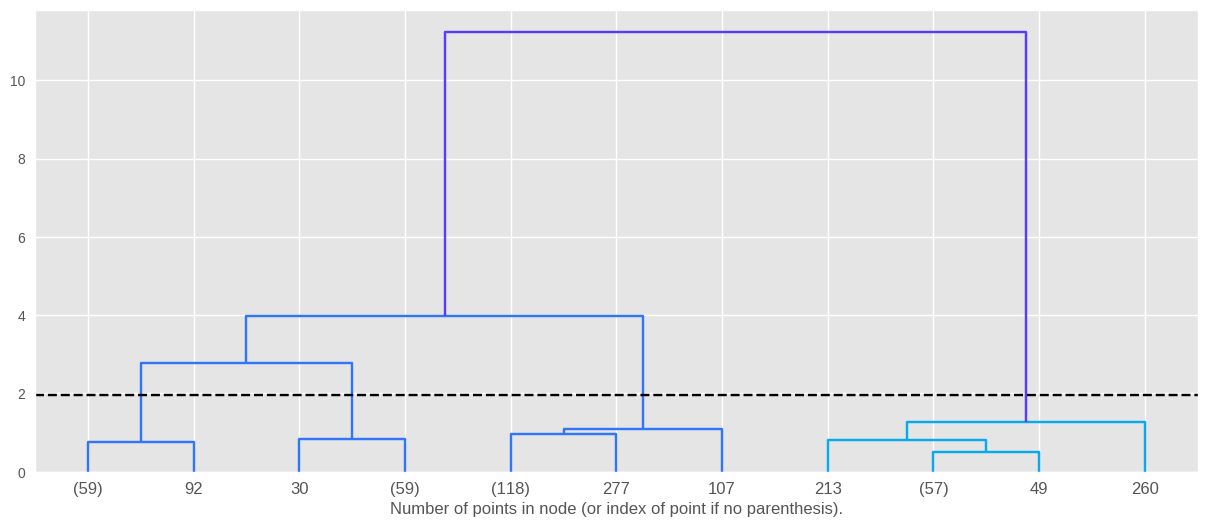

In [969]:
plt.figure(figsize = (15, 6))
plot_dendrogram(best_single_linkage, truncate_mode = "level", p = 3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(linestyle = '--', y = best_single_linkage_threshold * maior_distancia, c = 'black') 
plt.show()

#### **Complete Linkage**

Cria uma função para encapsular a execução do algoritmo Complete Linkage

In [970]:
def complete_linkage(threshold, dataset):
  cl = AgglomerativeClustering(linkage = 'complete', distance_threshold = threshold * maior_distancia, n_clusters = None).fit(dataset)

  return cl

Executa o Complete Linkage com thresholds variando de 0% a 100% da maior distânca encontrada entre os pontos da base de dados artificial e calcula o Rand Index Score.

Guarda o melhor agrupamento baseado no maior Rand Index encontrado durante a execução

In [971]:
complete_linkage_rand_scores = []
best_complete_linkage_rand_score = 0
best_complete_linkage = None
best_complete_linkage_threshold = 0

for i in np.linspace(0, 1, 11):
  cl = complete_linkage(i, x_artificial)

  rand_score = adjusted_rand_score(y_artificial, cl.labels_)
  complete_linkage_rand_scores.append(rand_score)

  if rand_score > best_complete_linkage_rand_score:
    best_complete_linkage_rand_score = rand_score
    best_complete_linkage = cl
    best_complete_linkage_threshold = i

silhouette_scores.append(silhouette_score(x_artificial, best_complete_linkage.labels_, metric='euclidean'))

Plota o gráfico do Rand Index calculado durante o loop do Complete Linkage.

Exibe o melhor agrupamento encontrado pelo algoritmo Complete Linkage

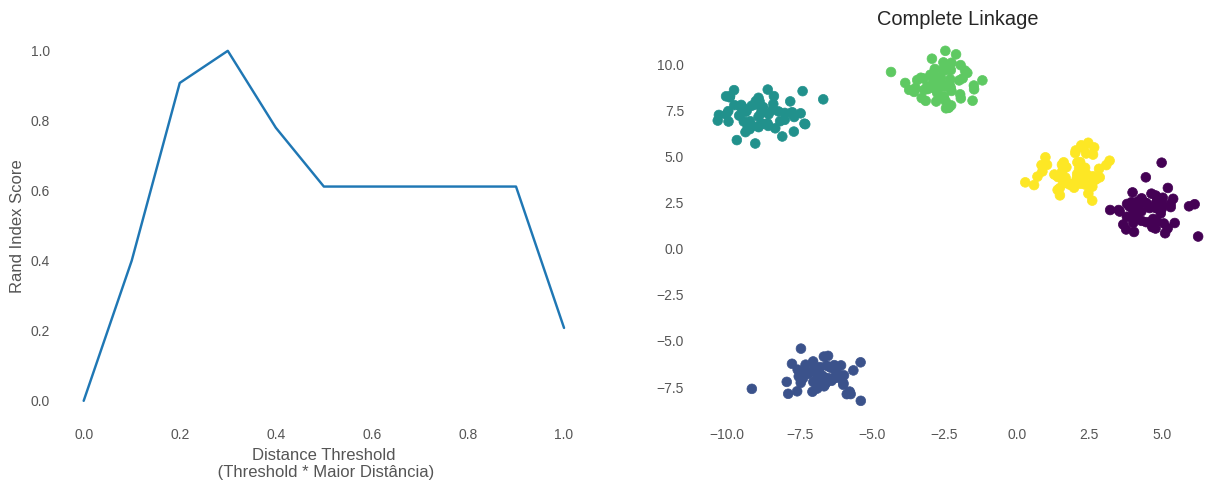

In [972]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(np.linspace(0, 1, 11), complete_linkage_rand_scores, 'tab:blue')
axs[0].set_xlabel('Distance Threshold\n (Threshold * Maior Distância)')
axs[0].set_ylabel("Rand Index Score")
axs[0].set_facecolor("white")

axs[1].scatter(x_artificial[:,0], x_artificial[:,1], c = best_complete_linkage.labels_, cmap = "viridis")
axs[1].set_title("Complete Linkage")
axs[1].set_facecolor("white")

fig.show()

Exibe o dendrograma do respectivo Complete Linkage (utilizamos o truncamento para uma melhor vizualização do dendograma já que como são muitos dados a exibição dos 300 pontos dificultava a interpretação)

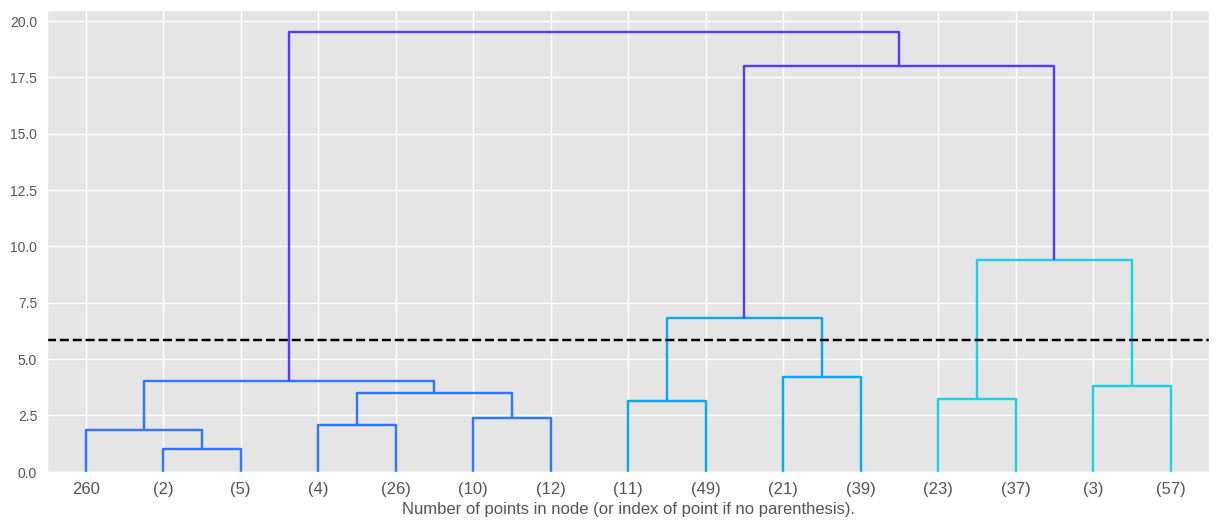

In [973]:
plt.figure(figsize = (15, 6))
plot_dendrogram(best_complete_linkage, truncate_mode = "level", p = 3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(linestyle = '--', y = best_complete_linkage_threshold * maior_distancia, c = 'black') 
plt.show()

#### **Average Linkage**

Cria uma função para encapsular a execução do algoritmo Average Linkage

In [974]:
def average_linkage(threshold, dataset):
  al = AgglomerativeClustering(linkage = 'average', distance_threshold = threshold * maior_distancia, n_clusters = None).fit(dataset)

  return al

Executa o Average Linkage com thresholds variando de 0% a 100% da maior distânca encontrada entre os pontos da base de dados artificial e calcula o Rand Index Score.

Guarda o melhor agrupamento baseado no maior Rand Index encontrado durante a execução

In [975]:
average_linkage_rand_scores = []
best_average_linkage_rand_score = 0
best_average_linkage = None
best_average_linkage_threshold = 0

for i in np.linspace(0, 1, 11):
  al = average_linkage(i, x_artificial)

  rand_score = adjusted_rand_score(y_artificial, al.labels_)
  average_linkage_rand_scores.append(rand_score)

  if rand_score > best_average_linkage_rand_score:
    best_average_linkage_rand_score = rand_score
    best_average_linkage = al
    best_average_linkage_threshold = i

silhouette_scores.append(silhouette_score(x_artificial, best_average_linkage.labels_, metric='euclidean'))

Plota o gráfico do Rand Index calculado durante o loop do Average Linkage.

Exibe o melhor agrupamento encontrado pelo algoritmo Average Linkage

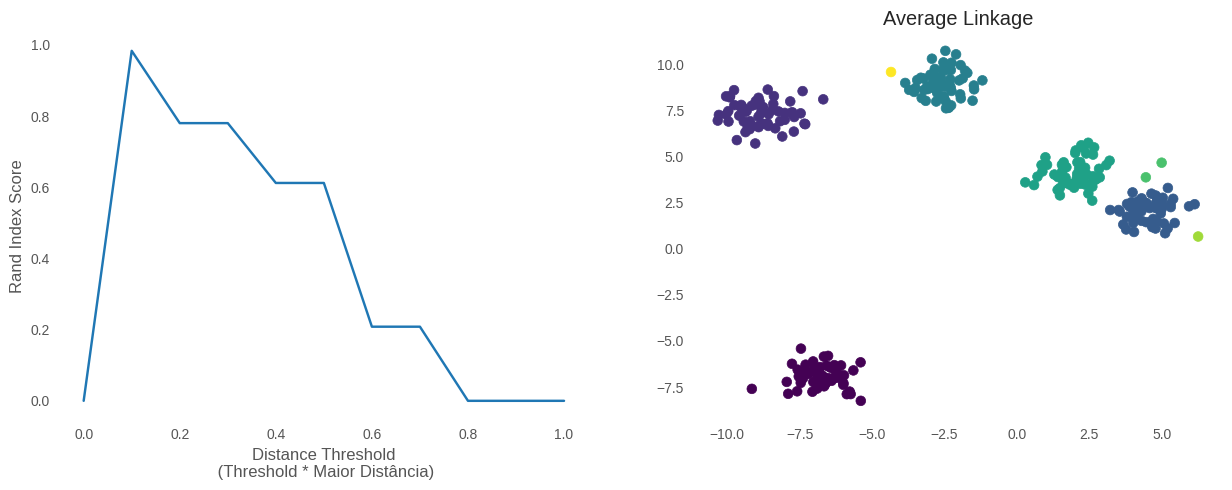

In [976]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(np.linspace(0, 1, 11), average_linkage_rand_scores, 'tab:blue')
axs[0].set_xlabel('Distance Threshold\n (Threshold * Maior Distância)')
axs[0].set_ylabel("Rand Index Score")
axs[0].set_facecolor("white")

axs[1].scatter(x_artificial[:,0], x_artificial[:,1], c = best_average_linkage.labels_, cmap = "viridis")
axs[1].set_title("Average Linkage")
axs[1].set_facecolor("white")

fig.show()

Exibe o dendrograma do respectivo Average Linkage (utilizamos o truncamento para uma melhor vizualização do dendograma já que como são muitos dados a exibição dos 300 pontos dificultava a interpretação)

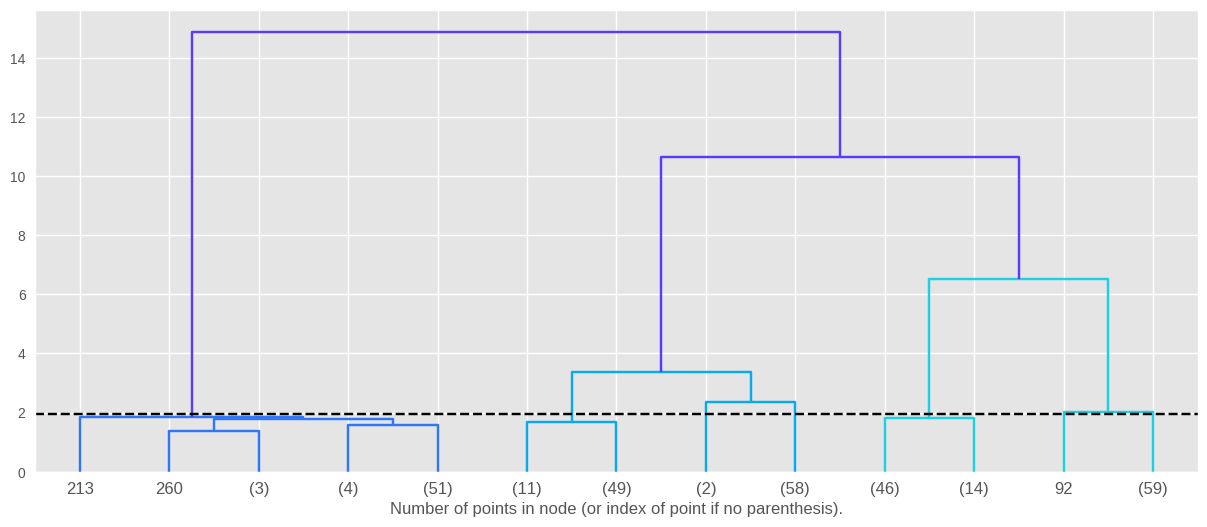

In [977]:
plt.figure(figsize = (15, 6))
plot_dendrogram(best_average_linkage, truncate_mode = "level", p = 3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(linestyle = '--', y = best_average_linkage_threshold * maior_distancia, c = 'black') 
plt.show()

#### **Centroid Linkage**

Cria uma função para encapsular a execução do algoritmo Centroid (Ward) Linkage

In [978]:
def centroid_linkage(threshold, dataset):
  wl = AgglomerativeClustering(linkage = 'ward', distance_threshold = threshold * maior_distancia, n_clusters = None).fit(dataset)

  return wl

Executa o Centroid Linkage com thresholds variando de 0% a 100% da maior distânca encontrada entre os pontos da base de dados artificial e calcula o Rand Index Score.

Guarda o melhor agrupamento baseado no maior Rand Index encontrado durante a execução

In [979]:
centroid_linkage_rand_scores = []
best_centroid_linkage_rand_score = 0
best_centroid_linkage = None
best_centroid_linkage_threshold = 0

for i in np.linspace(0, 1, 11):
  wl = centroid_linkage(i, x_artificial)

  rand_score = adjusted_rand_score(y_artificial, wl.labels_)
  centroid_linkage_rand_scores.append(rand_score)

  if rand_score > best_centroid_linkage_rand_score:
    best_centroid_linkage_rand_score = rand_score
    best_centroid_linkage = wl
    best_centroid_linkage_threshold = i

silhouette_scores.append(silhouette_score(x_artificial, best_centroid_linkage.labels_, metric='euclidean'))

Plota o gráfico do Rand Index calculado durante o loop do Centroid Linkage.

Exibe o melhor agrupamento encontrado pelo algoritmo Centroid Linkage

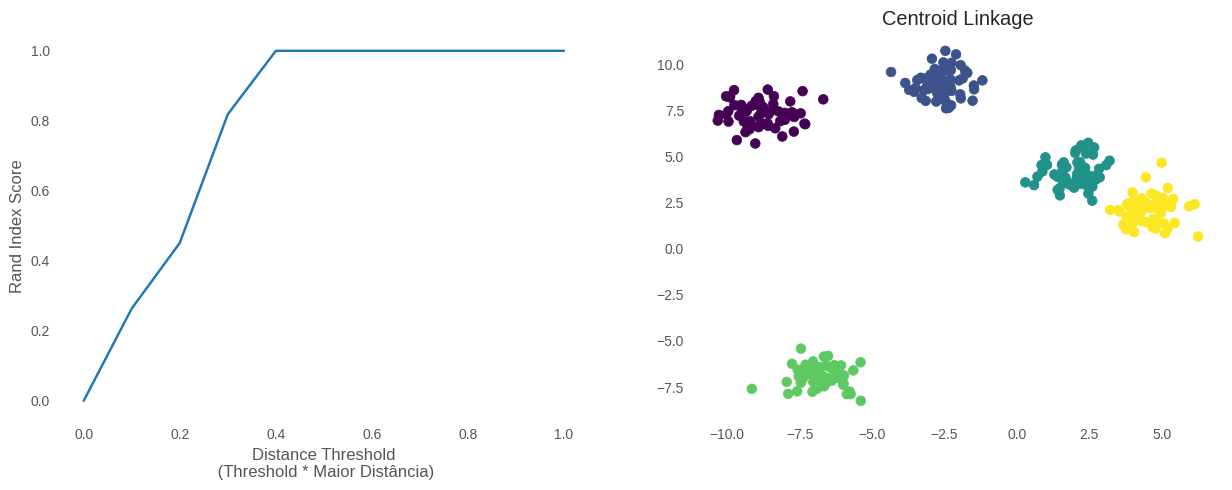

In [980]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(np.linspace(0, 1, 11), centroid_linkage_rand_scores, 'tab:blue')
axs[0].set_xlabel('Distance Threshold\n (Threshold * Maior Distância)')
axs[0].set_ylabel("Rand Index Score")
axs[0].set_facecolor("white")

axs[1].scatter(x_artificial[:,0], x_artificial[:,1], c = best_centroid_linkage.labels_, cmap = "viridis")
axs[1].set_title("Centroid Linkage")
axs[1].set_facecolor("white")

fig.show()

Exibe o dendrograma do respectivo Centroid Linkage (utilizamos o truncamento para uma melhor vizualização do dendograma já que como são muitos dados a exibição dos 300 pontos dificultava a interpretação)

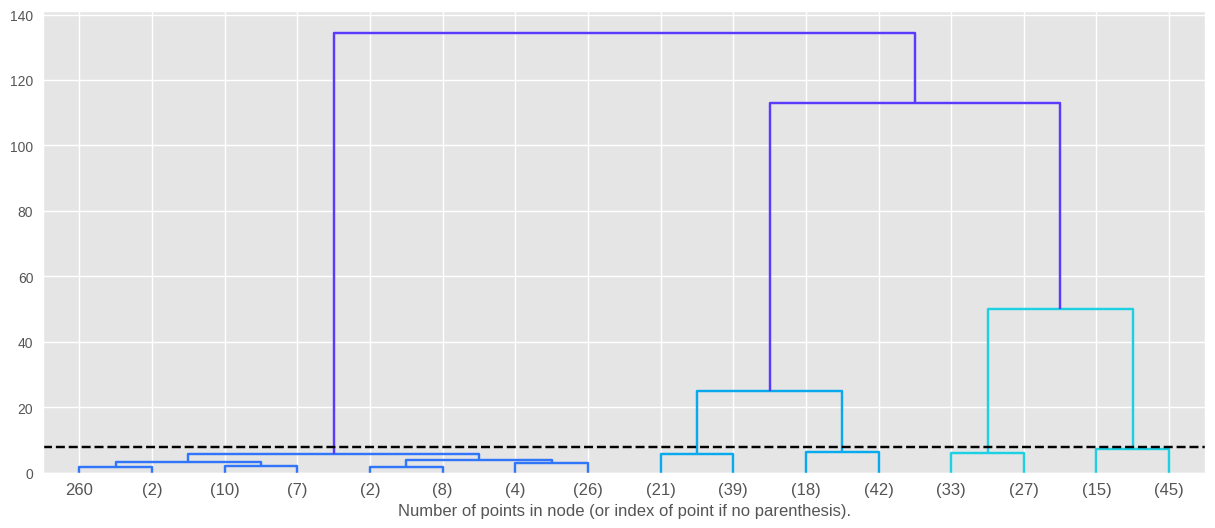

In [981]:
plt.figure(figsize = (15, 6))
plot_dendrogram(best_centroid_linkage, truncate_mode = "level", p = 3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(linestyle = '--', y = best_centroid_linkage_threshold * maior_distancia, c = 'black') 
plt.show()

#### **Comparativo de silhuetas**

Plota um comparativo entre as silhuetas calculadas para cada um dos algoritmos em seus melhores agrupamentos encontrados

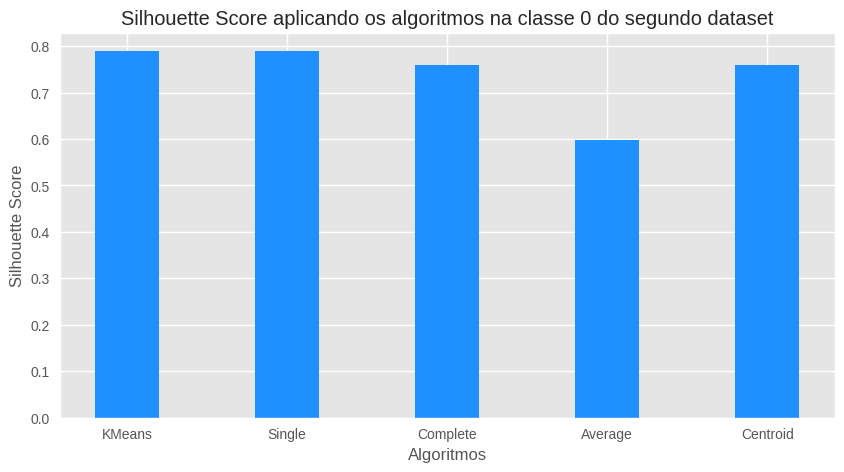

In [982]:
fig = plt.figure(figsize = (10, 5))
plt.bar(['KMeans', 'Single', 'Complete', 'Average', 'Centroid'], silhouette_scores, color ='dodgerblue', width = 0.4)
plt.xlabel("Algoritmos")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score aplicando os algoritmos na classe 0 do segundo dataset")
plt.show()

# **Bases de dados reais**

## Dataset 1 - Parkinsons

Carrega a primeira base de dados real extraída da UCI (disponível através do [link](https://archive-beta.ics.uci.edu/dataset/174/parkinsons))

In [983]:
parkinson_dataset = pd.read_csv("https://raw.githubusercontent.com/leojgpereira/t1-ia/main/parkinsons.csv")
parkinson_dataset

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,y
0,11999200,15730200,7499700,784,7,370,554,1109,4374,42600,...,6545,2211,2103300,414783,815285,-4813031,266482,2301442,284654,1
1,12240000,14865000,11381900,968,8,465,696,1394,6134,62600,...,9403,1929,1908500,458359,819521,-4075192,335590,2486855,368674,1
2,11668200,13111100,11155500,1050,9,544,781,1633,5233,48200,...,8270,1309,2065100,429895,825288,-4443179,311173,2342259,332634,1
3,11667600,13787100,11136600,997,9,502,698,1505,5492,51700,...,8771,1353,2064400,434969,819235,-4117501,334147,2405554,368975,1
4,11601400,14178100,11065500,1284,11,655,908,1966,6425,58400,...,10470,1767,1964900,417356,823484,-3747787,234513,2332180,410335,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,17418800,23097800,9426100,459,3,263,259,790,4087,40500,...,7008,2764,1951700,448439,657899,-6538586,121952,2657476,133050,0
191,20951600,25301700,8948800,564,3,331,292,994,2751,26300,...,4812,1810,1914700,431674,683244,-6195325,129303,2784312,168895,0
192,17468800,24000500,7428700,1360,8,624,564,1873,2308,25600,...,3804,10715,1788300,407567,655683,-6787197,158453,2679772,131728,0
193,19876400,39696100,7490400,740,4,370,390,1109,2296,24100,...,3794,7223,1902000,451221,643956,-6744577,207454,2138608,123306,0


### **Para classe 1 (Tem Parkinson)**

Cria array X e Y somente com as linhas com classe 1 -- portadoras da doença

In [984]:
x_parkinson = parkinson_dataset.loc[parkinson_dataset['y'] == 1]
y_parkinson = parkinson_dataset.loc[parkinson_dataset['y'] == 1]

x_parkinson = (x_parkinson.iloc[:, 0:-1]).to_numpy()
y_parkinson = (y_parkinson.iloc[:, -1]).to_numpy()

Calcula a distância entre todos os pontos da base de dados (considerando apenas os dados relativos a classe 1) e guarda a maior distância encontrada

In [985]:
distancias = pdist(x_parkinson, 'euclidean')
index_maior_distancia = distancias.argmax()
maior_distancia = distancias[index_maior_distancia]

maior_distancia

48753403.947634265

(Re)cria um vetor vazio para guardar o valor das silhuetas calculadas para cada algoritmo

In [986]:
silhouette_scores = []

#### KMeans

Executa o algoritmo KMeans na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo KMeans

Plota o agrupamento realizado pelo algoritmo

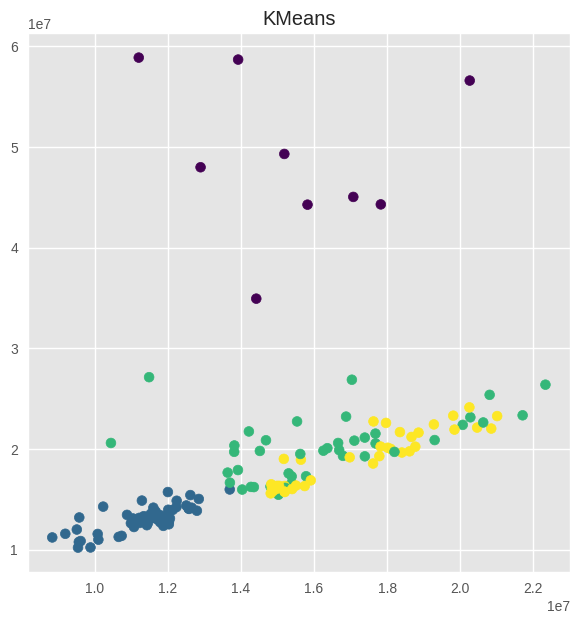

In [987]:
kmeans = algoritmo_kmeans(NUM_CLUSTERS, x_parkinson)

silhouette_scores.append(silhouette_score(x_parkinson, kmeans.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_parkinson[:,0], x_parkinson[:,1], c = kmeans.labels_, cmap = 'viridis')
plt.title("KMeans")
plt.show()

Utiliza a biblioteca vista em sala para demonstrar o comportamento dos itens da base baseado na silhueta de cada item

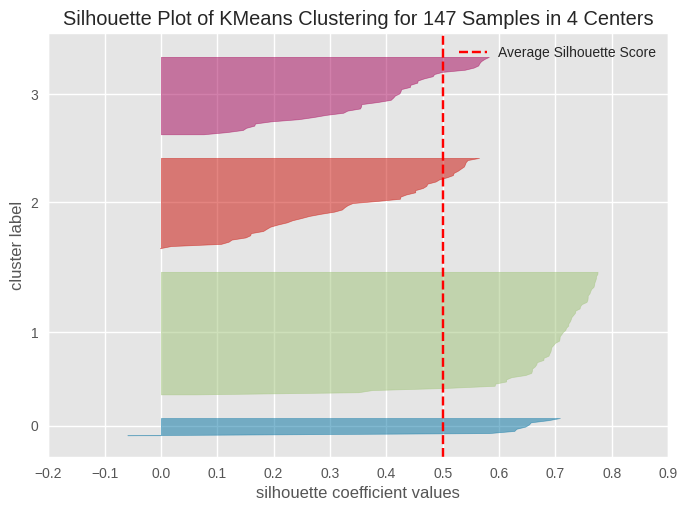

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 147 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [988]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(x_parkinson)
visualizer.show()

#### Single Linkage

Executa o algoritmo Single Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Single Linkage

Plota o agrupamento realizado pelo algoritmo

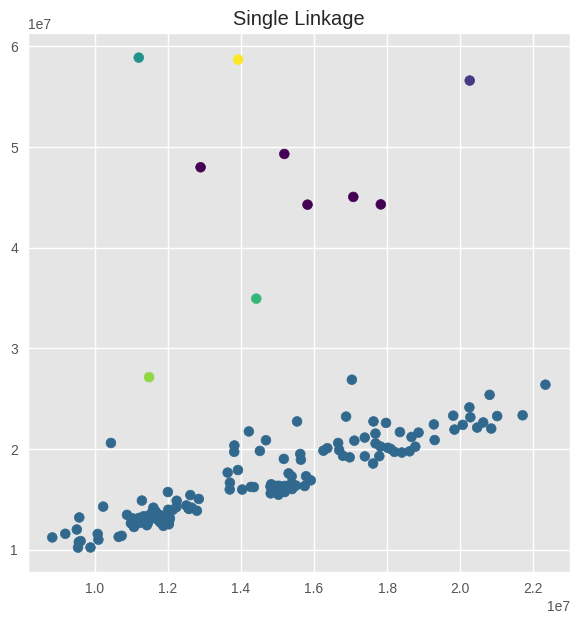

In [989]:
sl = single_linkage(0.1, x_parkinson)

silhouette_scores.append(silhouette_score(x_parkinson, sl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_parkinson[:,0], x_parkinson[:,1], c = sl.labels_, cmap = 'viridis')
plt.title("Single Linkage")
plt.show()

#### Complete Linkage

Executa o algoritmo Complete Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Complete Linkage

Plota o agrupamento realizado pelo algoritmo

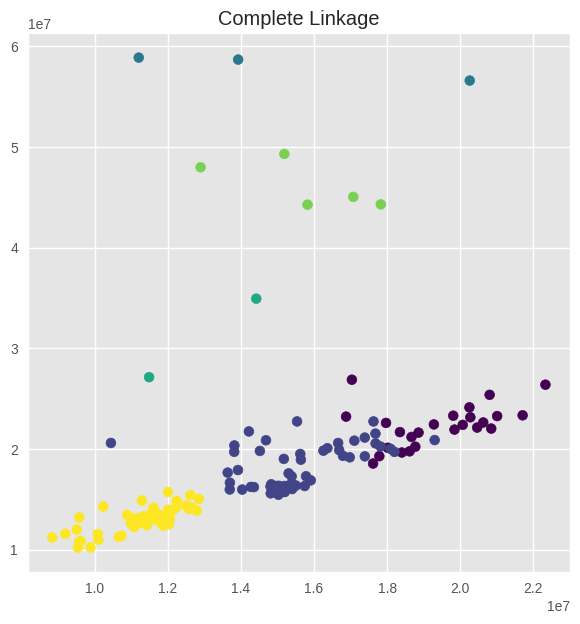

In [990]:
cl = complete_linkage(0.3, x_parkinson)

silhouette_scores.append(silhouette_score(x_parkinson, cl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_parkinson[:,0], x_parkinson[:,1], c = cl.labels_, cmap = 'viridis')
plt.title("Complete Linkage")
plt.show()

#### Average Linkage

Executa o algoritmo Average Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Average Linkage

Plota o agrupamento realizado pelo algoritmo

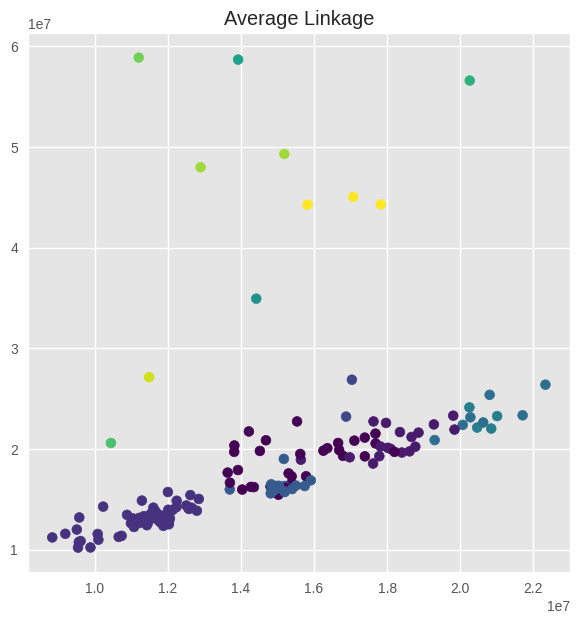

In [991]:
al = average_linkage(0.1, x_parkinson)

silhouette_scores.append(silhouette_score(x_parkinson, al.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_parkinson[:,0], x_parkinson[:,1], c = al.labels_, cmap = 'viridis')
plt.title("Average Linkage")
plt.show()

#### Centroid Linkage

Executa o algoritmo Centroid Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Centroid Linkage

Plota o agrupamento realizado pelo algoritmo

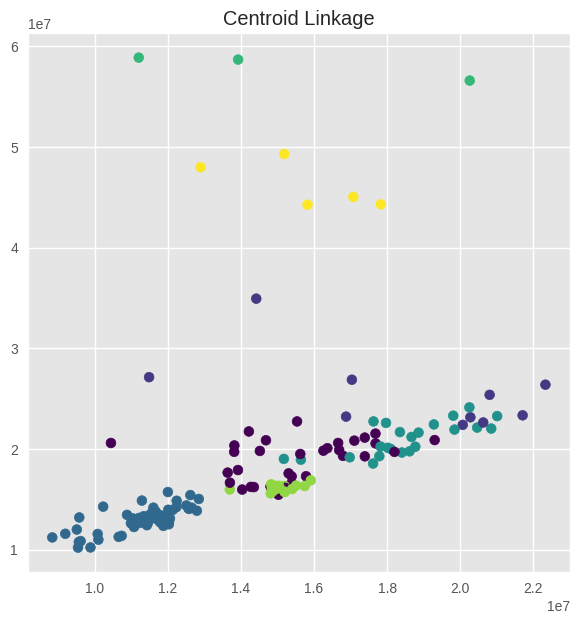

In [992]:
wl = centroid_linkage(0.4, x_parkinson)

silhouette_scores.append(silhouette_score(x_parkinson, wl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_parkinson[:,0], x_parkinson[:,1], c = wl.labels_, cmap = 'viridis')
plt.title("Centroid Linkage")
plt.show()

#### Comparação de Silhueta

Plota um comparativo entre as silhuetas calculadas para cada um dos algoritmos

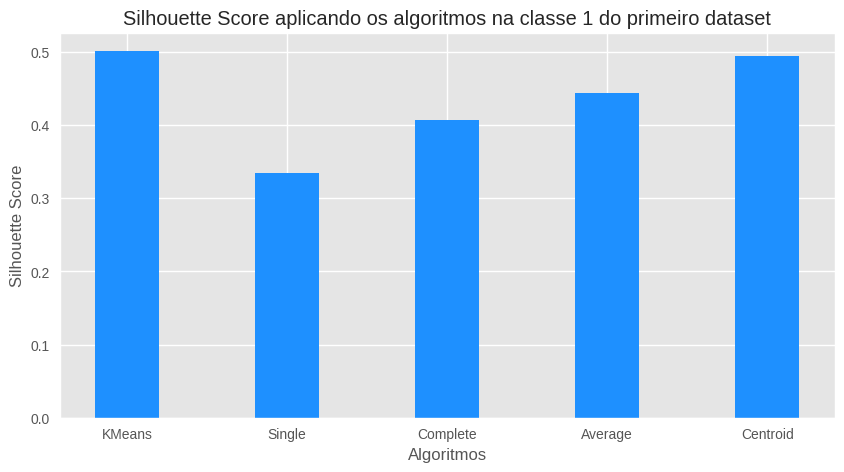

In [993]:
fig = plt.figure(figsize = (10, 5))
plt.bar(['KMeans', 'Single', 'Complete', 'Average', 'Centroid'], silhouette_scores, color ='dodgerblue', width = 0.4)
plt.xlabel("Algoritmos")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score aplicando os algoritmos na classe 1 do primeiro dataset")
plt.show()

### **Para classe 0 (Não tem Parkinson)**

Cria array X e Y somente com as linhas com classe 0 -- não portadoras da doença

In [994]:
x_n_parkinson = parkinson_dataset.loc[parkinson_dataset['y'] == 0]
y_n_parkinson = parkinson_dataset.loc[parkinson_dataset['y'] == 0]

x_n_parkinson = (x_n_parkinson.iloc[:, 0:-1]).to_numpy()
y_n_parkinson = (y_n_parkinson.iloc[:, -1]).to_numpy()

Calcula a distância entre todos os pontos da base de dados (considerando apenas os dados relativos a classe 0) e guarda a maior distância encontrada

In [995]:
distancias = pdist(x_n_parkinson, 'euclidean')
index_maior_distancia = distancias.argmax()
maior_distancia = distancias[index_maior_distancia]

maior_distancia

47870357.06490122

(Re)cria um vetor vazio para guardar o valor das silhuetas calculadas para cada algoritmo

In [996]:
silhouette_scores = []

#### KMeans

Executa o algoritmo KMeans na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo KMeans

Plota o agrupamento realizado pelo algoritmo

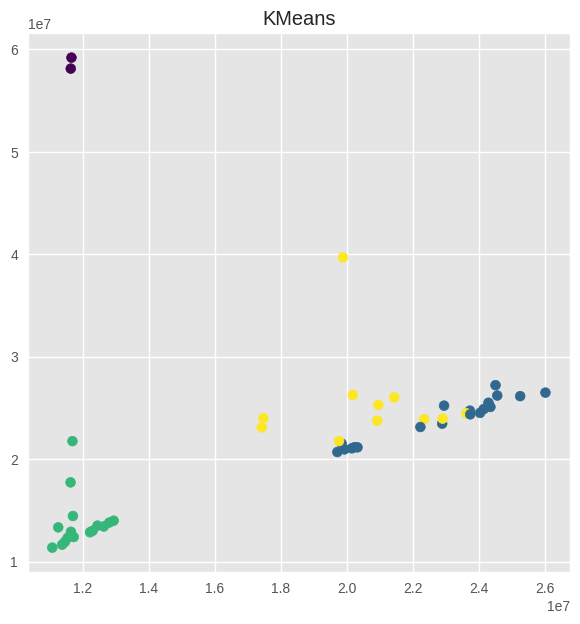

In [997]:
kmeans = algoritmo_kmeans(NUM_CLUSTERS, x_n_parkinson)

silhouette_scores.append(silhouette_score(x_n_parkinson, kmeans.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_n_parkinson[:,0], x_n_parkinson[:,1], c = kmeans.labels_, cmap = 'viridis')
plt.title("KMeans")
plt.show()

Utiliza a biblioteca vista em sala para demonstrar o comportamento dos itens da base baseado na silhueta de cada item

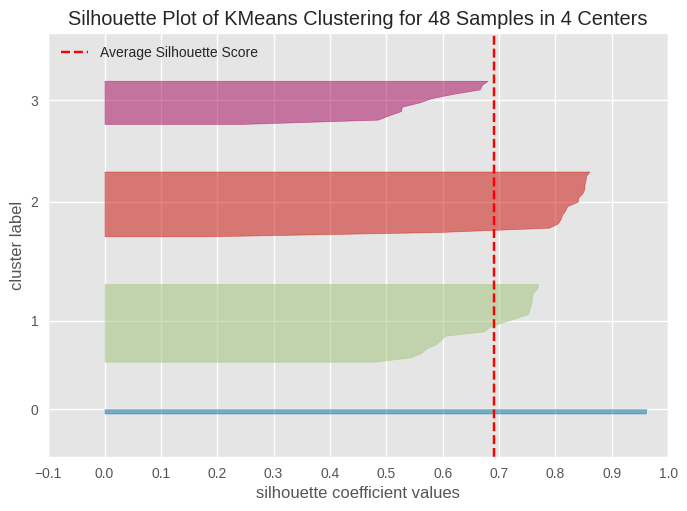

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 48 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [998]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(x_n_parkinson)
visualizer.show()

#### Single Linkage

Executa o algoritmo Single Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Single Linkage

Plota o agrupamento realizado pelo algoritmo

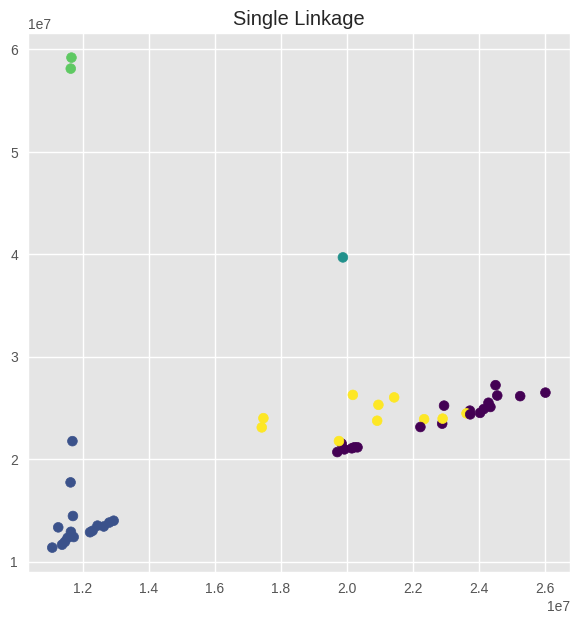

In [999]:
sl = single_linkage(0.1, x_n_parkinson)

silhouette_scores.append(silhouette_score(x_n_parkinson, kmeans.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_n_parkinson[:,0], x_n_parkinson[:,1], c = sl.labels_, cmap = 'viridis')
plt.title("Single Linkage")
plt.show()

#### Complete Linkage

Executa o algoritmo Complete Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Complete Linkage

Plota o agrupamento realizado pelo algoritmo

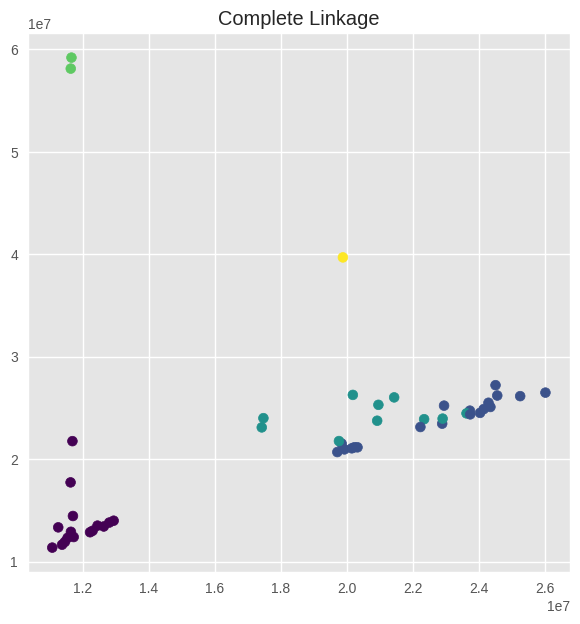

In [1000]:
cl = complete_linkage(0.3, x_n_parkinson)

silhouette_scores.append(silhouette_score(x_n_parkinson, cl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_n_parkinson[:,0], x_n_parkinson[:,1], c = cl.labels_, cmap = 'viridis')
plt.title("Complete Linkage")
plt.show()

#### Average Linkage

Executa o algoritmo Average Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Average Linkage

Plota o agrupamento realizado pelo algoritmo

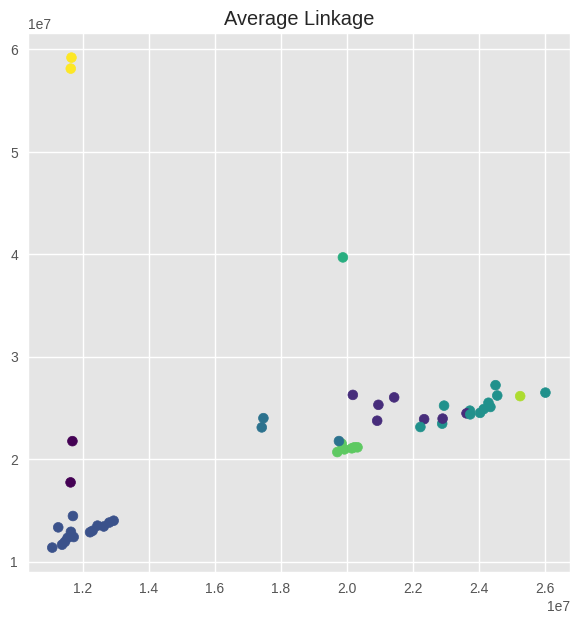

In [1001]:
al = average_linkage(0.1, x_n_parkinson)

silhouette_scores.append(silhouette_score(x_n_parkinson, al.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_n_parkinson[:,0], x_n_parkinson[:,1], c = al.labels_, cmap = 'viridis')
plt.title("Average Linkage")
plt.show()

#### Centroid Linkage

Executa o algoritmo Centroid Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Centroid Linkage

Plota o agrupamento realizado pelo algoritmo

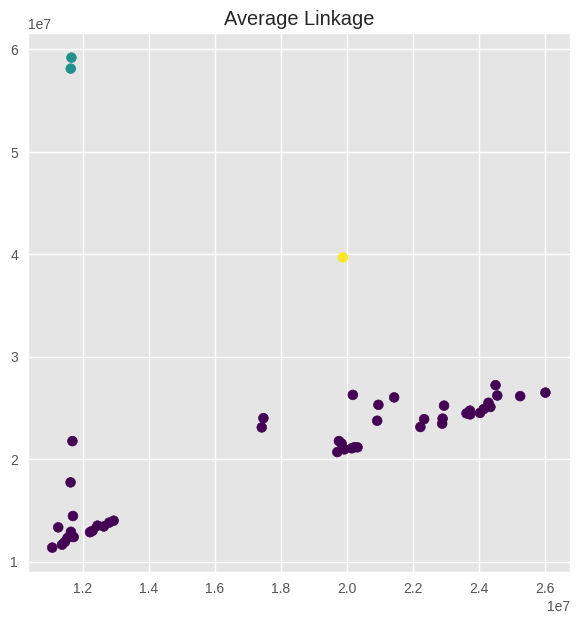

In [1002]:
wl = average_linkage(0.4, x_n_parkinson)

silhouette_scores.append(silhouette_score(x_n_parkinson, wl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_n_parkinson[:,0], x_n_parkinson[:,1], c = wl.labels_, cmap = 'viridis')
plt.title("Average Linkage")
plt.show()

#### Comparativo de silhuetas

Plota um comparativo entre as silhuetas calculadas para cada um dos algoritmos

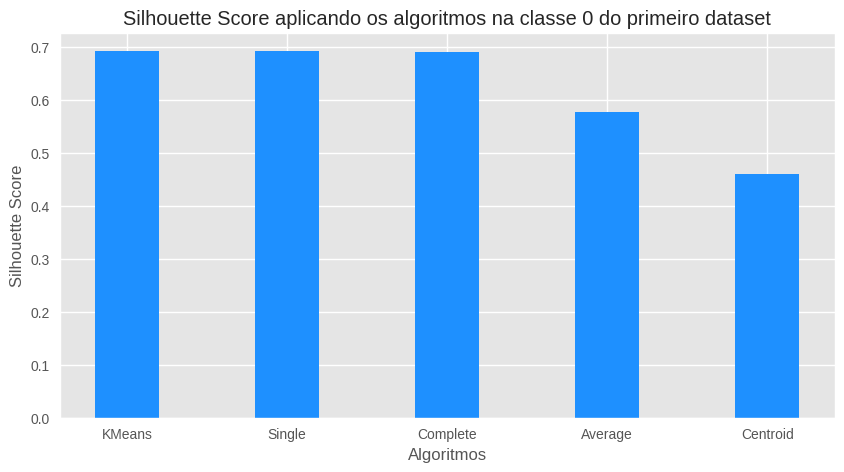

In [1003]:
fig = plt.figure(figsize = (10, 5))
plt.bar(['KMeans', 'Single', 'Complete', 'Average', 'Centroid'], silhouette_scores, color ='dodgerblue', width = 0.4)
plt.xlabel("Algoritmos")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score aplicando os algoritmos na classe 0 do primeiro dataset")
plt.show()

## Dataset 2 - Breast Cancer

Carrega a segunda base de dados real extraída da UCI (disponível através do [link](https://archive-beta.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic))

In [1004]:
cancer_dataset = pd.read_csv("https://raw.githubusercontent.com/leojgpereira/t1-ia/main/wdbc.csv")
cancer_dataset

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
0,17.99,10.38,122.80,1001.0,1184.0,2776.0,3001.0,1471,2419.0,7871.0,...,17.33,184.60,2019.0,1622.0,6656.0,7119.0,2654.0,4601.0,1189.0,1
1,20.57,17.77,132.90,1326.0,8474.0,7864.0,869.0,7017,1812.0,5667.0,...,23.41,158.80,1956.0,1238.0,1866.0,2416.0,186.0,275.0,8902.0,1
2,19.69,21.25,130.00,1203.0,1096.0,1599.0,1974.0,1279,2069.0,5999.0,...,25.53,152.50,1709.0,1444.0,4245.0,4504.0,243.0,3613.0,8758.0,1
3,11.42,20.38,77.58,386.1,1425.0,2839.0,2414.0,1052,2597.0,9744.0,...,45072.00,98.87,567.7,2098.0,8663.0,6869.0,2575.0,6638.0,173.0,1
4,20.29,14.34,135.10,1297.0,1003.0,1328.0,198.0,1043,1809.0,5883.0,...,16.67,152.20,1575.0,1374.0,205.0,0.4,1625.0,2364.0,7678.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,111.0,1159.0,2439.0,1389,1726.0,5623.0,...,45042.00,166.10,2027.0,141.0,2113.0,4107.0,2216.0,206.0,7115.0,1
565,20.13,28.25,131.20,1261.0,978.0,1034.0,144.0,9791,1752.0,5533.0,...,38.25,155.00,1731.0,1166.0,1922.0,3215.0,1628.0,2572.0,6637.0,1
566,45093.00,45166.00,108.30,858.1,8455.0,1023.0,9251.0,5302,159.0,5648.0,...,34.12,126.70,1124.0,1139.0,3094.0,3403.0,1418.0,2218.0,782.0,1
567,45097.00,29.33,140.10,1265.0,1178.0,277.0,3514.0,152,2397.0,7016.0,...,39.42,184.60,1821.0,165.0,8681.0,9387.0,265.0,4087.0,124.0,1


### **Para classe 1 (Máligno)**

Cria array X e Y somente com as linhas com classe 1 -- câncer máligno

In [1005]:
x_maligno = cancer_dataset.loc[cancer_dataset['y'] == 1]
y_maligno = cancer_dataset.loc[cancer_dataset['y'] == 1]

x_maligno = (x_maligno.iloc[:, 0:-1]).to_numpy()
y_maligno = (y_maligno.iloc[:, -1]).to_numpy()

Calcula a distância entre todos os pontos da base de dados (considerando apenas os dados relativos a classe 1) e guarda a maior distância encontrada

In [1006]:
distancias = pdist(x_maligno, 'euclidean')
index_maior_distancia = distancias.argmax()
maior_distancia = distancias[index_maior_distancia]

maior_distancia

102791.38803626741

(Re)cria um vetor vazio para guardar o valor das silhuetas calculadas para cada algoritmo

In [1007]:
silhouette_scores = []

#### KMeans

Executa o algoritmo KMeans na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo KMeans

Plota o agrupamento realizado pelo algoritmo

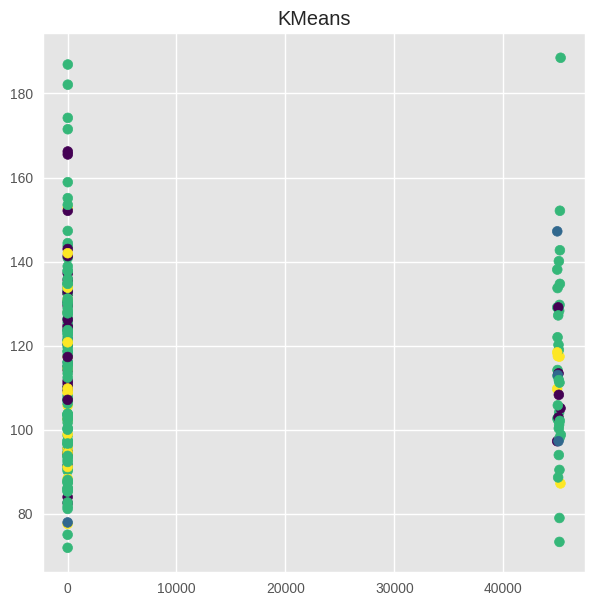

In [1008]:
kmeans = algoritmo_kmeans(NUM_CLUSTERS, x_maligno)

silhouette_scores.append(silhouette_score(x_maligno, kmeans.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_maligno[:,0], x_maligno[:,2], c = kmeans.labels_, cmap = 'viridis')
plt.title("KMeans")
plt.show()

Utiliza a biblioteca vista em sala para demonstrar o comportamento dos itens da base baseado na silhueta de cada item

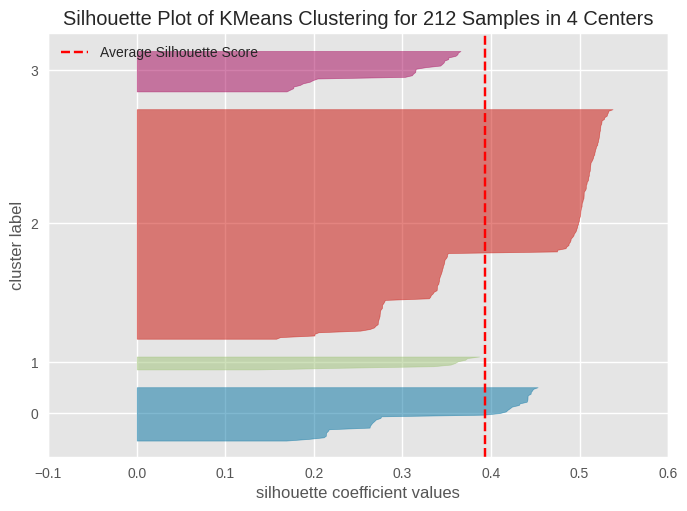

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 212 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [1009]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(x_maligno)
visualizer.show()

#### Single Linkage

Executa o algoritmo Single Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Single Linkage

Plota o agrupamento realizado pelo algoritmo

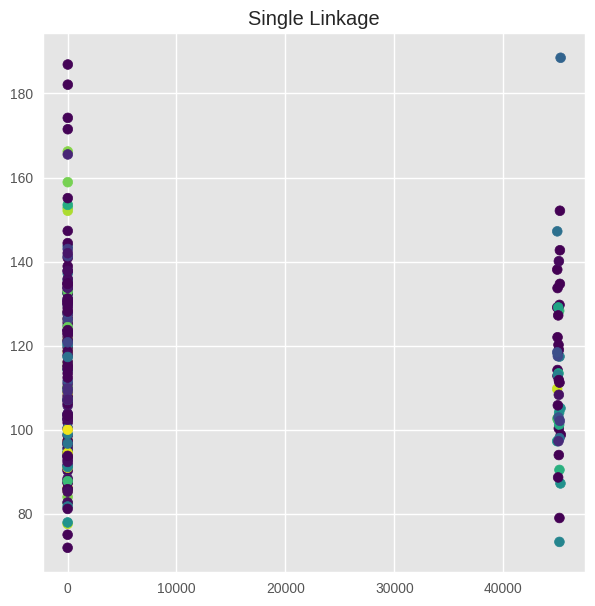

In [1010]:
sl = single_linkage(0.1, x_maligno)

silhouette_scores.append(silhouette_score(x_maligno, sl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_maligno[:,0], x_maligno[:,2], c = sl.labels_, cmap = 'viridis')
plt.title("Single Linkage")
plt.show()

#### Complete Linkage

Executa o algoritmo Complete Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Complete Linkage

Plota o agrupamento realizado pelo algoritmo

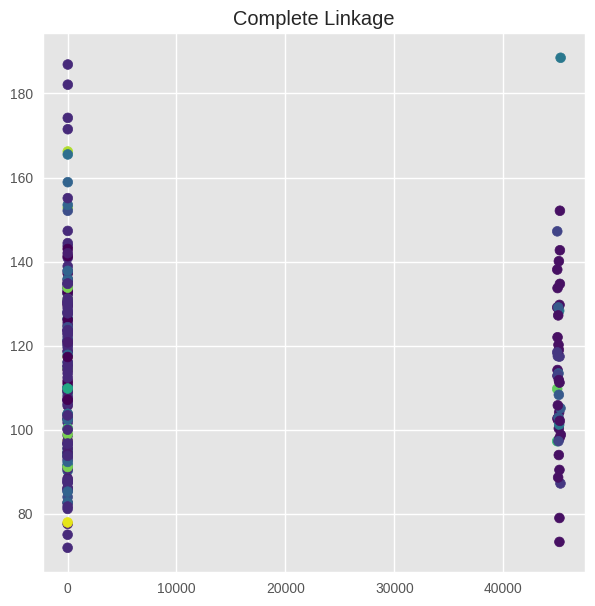

In [1011]:
cl = complete_linkage(0.3, x_maligno)

silhouette_scores.append(silhouette_score(x_maligno, cl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_maligno[:,0], x_maligno[:,2], c = cl.labels_, cmap = 'viridis')
plt.title("Complete Linkage")
plt.show()

#### Average Linkage

Executa o algoritmo Average Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Average Linkage

Plota o agrupamento realizado pelo algoritmo

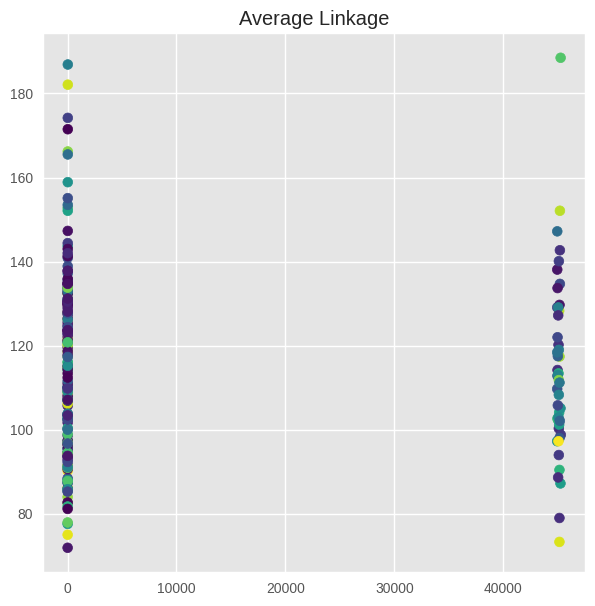

In [1012]:
al = average_linkage(0.1, x_maligno)

silhouette_scores.append(silhouette_score(x_maligno, al.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_maligno[:,0], x_maligno[:,2], c = al.labels_, cmap = 'viridis')
plt.title("Average Linkage")
plt.show()

#### Centroid Linkage

Executa o algoritmo Centroid Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Centroid Linkage

Plota o agrupamento realizado pelo algoritmo

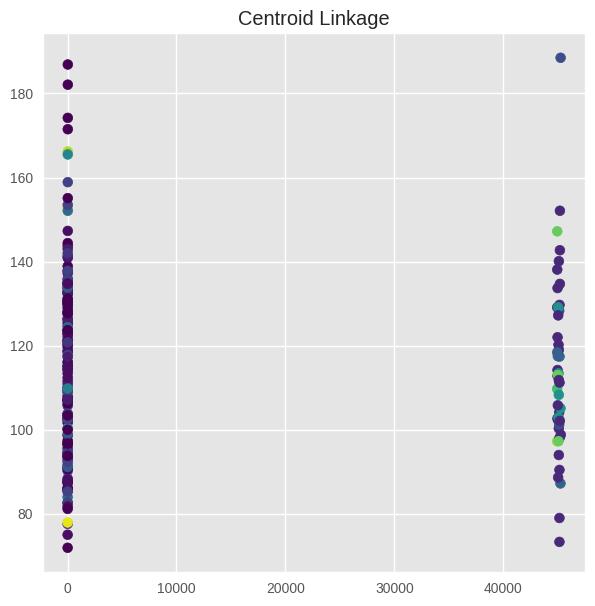

In [1013]:
wl = centroid_linkage(0.4, x_maligno)

silhouette_scores.append(silhouette_score(x_maligno, wl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_maligno[:,0], x_maligno[:,2], c = wl.labels_, cmap = 'viridis')
plt.title("Centroid Linkage")
plt.show()

#### Comparativo de silhuetas

Plota um comparativo entre as silhuetas calculadas para cada um dos algoritmos

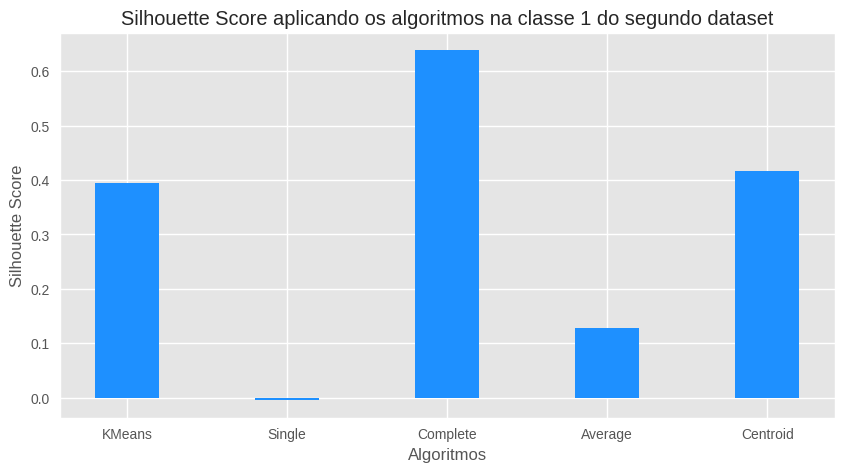

In [1014]:
fig = plt.figure(figsize = (10, 5))
plt.bar(['KMeans', 'Single', 'Complete', 'Average', 'Centroid'], silhouette_scores, color ='dodgerblue', width = 0.4)
plt.xlabel("Algoritmos")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score aplicando os algoritmos na classe 1 do segundo dataset")
plt.show()

### **Para classe 0 (Benigno)**

Cria array X e Y somente com as linhas com classe 0 -- câncer benigno

In [1015]:
x_benigno = cancer_dataset.loc[cancer_dataset['y'] == 0]
y_benigno = cancer_dataset.loc[cancer_dataset['y'] == 0]

x_benigno = (x_benigno.iloc[:, 0:-1]).to_numpy()
y_benigno = (y_benigno.iloc[:, -1]).to_numpy()

Calcula a distância entre todos os pontos da base de dados (considerando apenas os dados relativos a classe 0) e guarda a maior distância encontrada

In [1016]:
distancias = pdist(x_benigno, 'euclidean')
index_maior_distancia = distancias.argmax()
maior_distancia = distancias[index_maior_distancia]

maior_distancia

111192.93016201525

(Re)cria um vetor vazio para guardar o valor das silhuetas calculadas para cada algoritmo

In [1017]:
silhouette_scores = []

#### KMeans

Executa o algoritmo KMeans na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo KMeans

Plota o agrupamento realizado pelo algoritmo

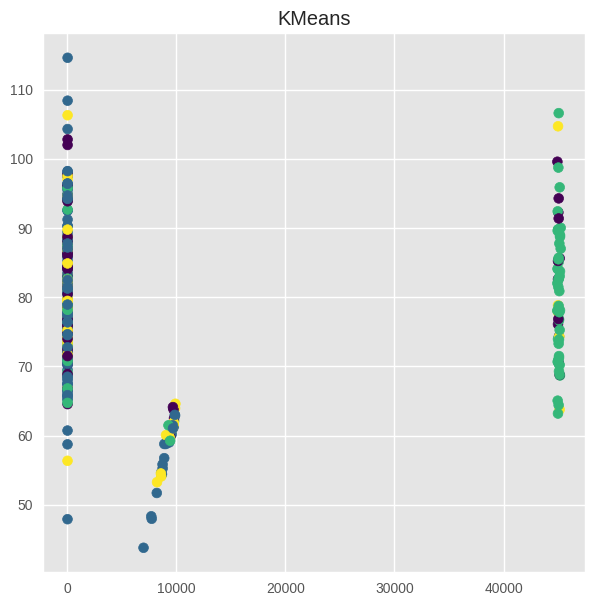

In [1018]:
kmeans = algoritmo_kmeans(NUM_CLUSTERS, x_benigno)

silhouette_scores.append(silhouette_score(x_benigno, kmeans.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_benigno[:,0], x_benigno[:,2], c = kmeans.labels_, cmap = 'viridis')
plt.title("KMeans")
plt.show()

Utiliza a biblioteca vista em sala para demonstrar o comportamento dos itens da base baseado na silhueta de cada item

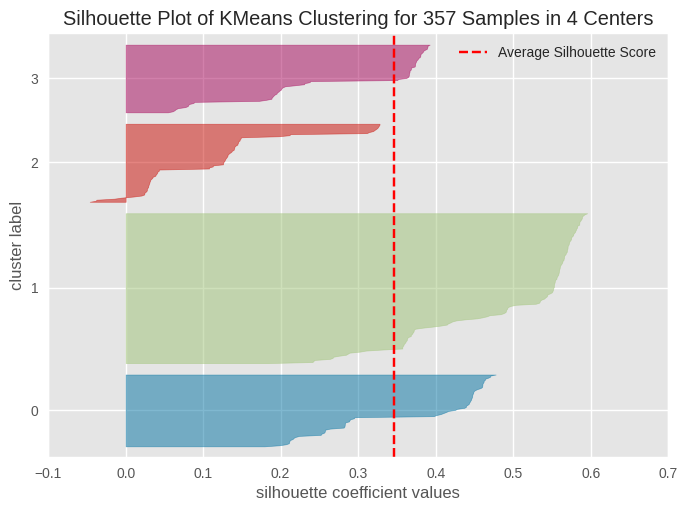

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 357 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [1019]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(x_benigno)
visualizer.show()

#### Single Linkage

Executa o algoritmo Single Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Single Linkage

Plota o agrupamento realizado pelo algoritmo

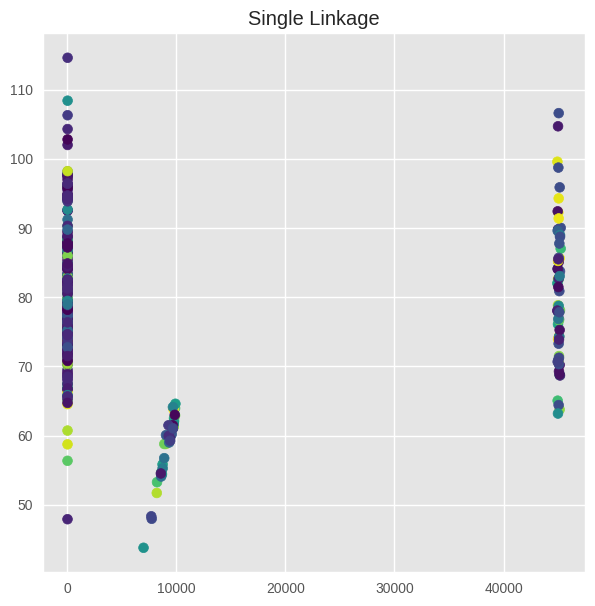

In [1020]:
sl = single_linkage(0.1, x_benigno)

silhouette_scores.append(silhouette_score(x_benigno, sl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_benigno[:,0], x_benigno[:,2], c = sl.labels_, cmap = 'viridis')
plt.title("Single Linkage")
plt.show()

#### Complete Linkage

Executa o algoritmo Complete Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Complete Linkage

Plota o agrupamento realizado pelo algoritmo

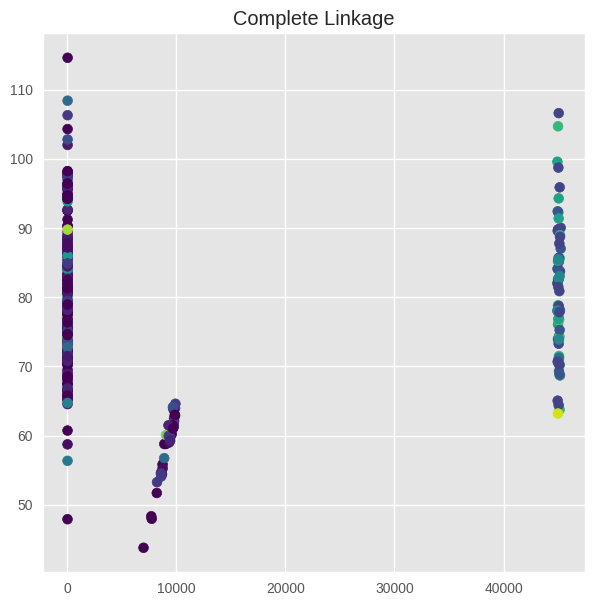

In [1021]:
cl = complete_linkage(0.3, x_benigno)

silhouette_scores.append(silhouette_score(x_benigno, cl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_benigno[:,0], x_benigno[:,2], c = cl.labels_, cmap = 'viridis')
plt.title("Complete Linkage")
plt.show()

#### Average Linkage

Executa o algoritmo Average Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Average Linkage

Plota o agrupamento realizado pelo algoritmo

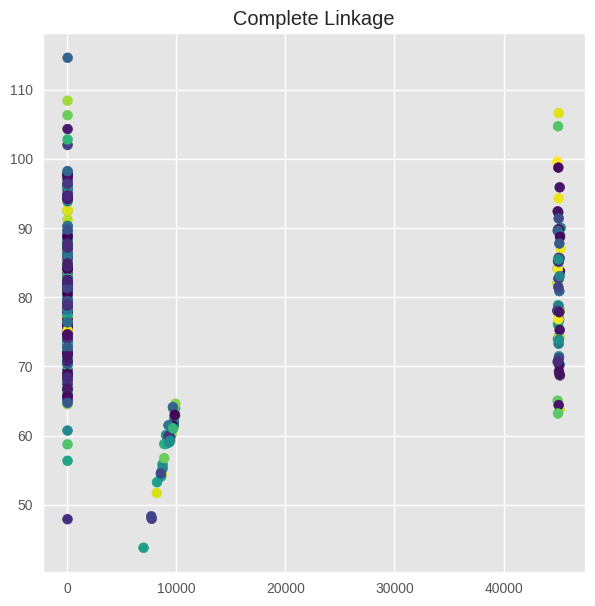

In [1022]:
al = average_linkage(0.1, x_benigno)

silhouette_scores.append(silhouette_score(x_benigno, al.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_benigno[:,0], x_benigno[:,2], c = al.labels_, cmap = 'viridis')
plt.title("Complete Linkage")
plt.show()

#### Centroid Linkage

Executa o algoritmo Centroid Linkage na base de dados real com os parâmetros definidos avaliando a execução do algoritmo na base artificial

Calcula a silhueta média da base ao utilizar o algoritmo Centroid Linkage

Plota o agrupamento realizado pelo algoritmo

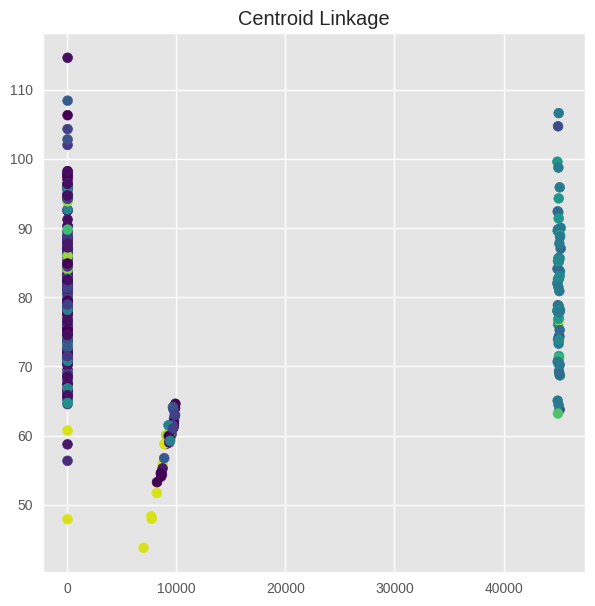

In [1023]:
wl = centroid_linkage(0.4, x_benigno)

silhouette_scores.append(silhouette_score(x_benigno, wl.labels_, metric='euclidean'))

plt.figure(figsize = (7, 7))
plt.scatter(x_benigno[:,0], x_benigno[:,2], c = wl.labels_, cmap = 'viridis')
plt.title("Centroid Linkage")
plt.show()

#### Comparativo de silhuetas

Plota um comparativo entre as silhuetas calculadas para cada um dos algoritmos

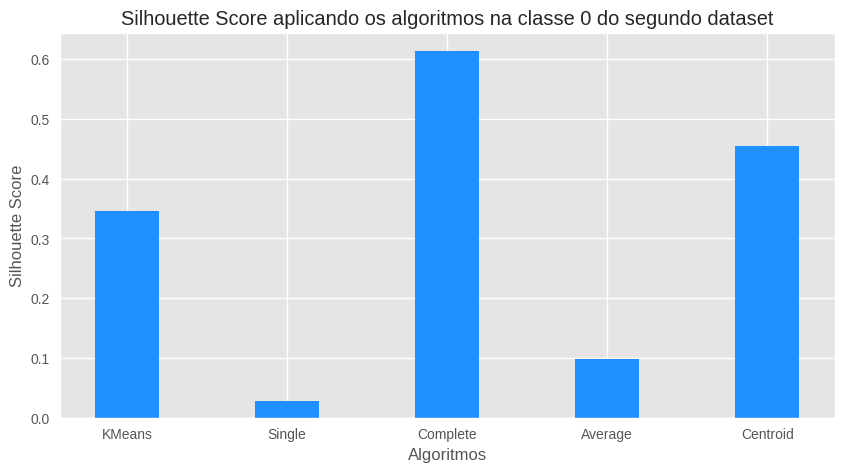

In [1024]:
fig = plt.figure(figsize = (10, 5))
plt.bar(['KMeans', 'Single', 'Complete', 'Average', 'Centroid'], silhouette_scores, color ='dodgerblue', width = 0.4)
plt.xlabel("Algoritmos")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score aplicando os algoritmos na classe 0 do segundo dataset")
plt.show()